### Linear Model Selection and Regularization

You use the `glmnet` package to perform lasso regression. `parsnip` does not have a dedicated function to create a ridge regression model specification. You need to use `linear_reg()` and set `mixture = 1` to specify a lasso model. The mixture argument specifies the amount of different types of regularization, `mixture = 0` specifies only ridge regularization and `mixture = 1` specifies only lasso regularization. Setting `mixture` to a value between 0 and 1 lets us use both.

The following procedure will be very similar to what we saw in the ridge regression section. The preprocessing needed is the same, but let us write it out again.

In [1]:
# Run this code from the previous assignment to get you properly started. 

library(tidymodels)
library(ISLR2)
Hitters <- as_tibble(Hitters) %>%
  filter(!is.na(Salary))

Hitters_split <- initial_split(Hitters, strata = "Salary")
Hitters_train <- training(Hitters_split)
Hitters_test <- testing(Hitters_split)
Hitters_fold <- vfold_cv(Hitters_train, v = 10)

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.4     ✔ recipes      1.0.5
✔ dials        1.1.0     ✔ rsample      1.1.1
✔ dplyr        1.1.0     ✔ tibble       3.2.0
✔ ggplot2      3.4.1     ✔ tidyr        1.3.0
✔ infer        1.0.4     ✔ tune         1.0.1
✔ modeldata    1.1.0     ✔ workflows    1.1.3
✔ parsnip      1.0.4     ✔ workflowsets 1.0.0
✔ purrr        1.0.1     ✔ yardstick    1.1.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Use tidymodels_prefer() to resolve common conflicts.



Run the Block of code below 

In [2]:
lasso_recipe <- 
  recipe(formula = Salary ~ ., data = Hitters_train) %>% 
  step_novel(all_nominal_predictors()) %>% 
  step_dummy(all_nominal_predictors()) %>% 
  step_zv(all_predictors()) %>% 
  step_normalize(all_predictors())

Next, finish the lasso regression `workflow`. Have the two outputs `lasso_spec` and `lasso_workflow` respectively. For the `lasso_spec` output use the functions `linear_reg`, `set_mode` and `set_engine` functions. For the `lasso_workflow` output use the `add_recipe` and `add_model` outputs. 

In [3]:
lasso_spec <- 
  linear_reg(penalty = tune(), mixture = 1) %>% 
  set_mode("regression") %>% 
  set_engine("glmnet") 

lasso_workflow <- workflow() %>% 
  add_recipe(lasso_recipe) %>% 
  add_model(lasso_spec)

While you are doing a different kind of regularization you will still use the same `penalty` argument. I have picked a different range for the values of penalty since I know it will be a good range. You would in practice have to cast a wide net at first and then narrow on the range of interest. Use the output `penalty_grid`. Use `50` levels and set a range going from [-2,2]. Use the function `grid_regular`. 

In [4]:
# *your code here*

penalty_grid <- grid_regular(penalty(range = c(-2,2), trans = log10_trans()), levels = 50)  

# your code here



In [5]:
library(testthat)

expect_equal(penalty_grid$penalty[1], 0.01)
expect_equal(penalty_grid$penalty[25], 0.910298177991522)
expect_equal(penalty_grid$penalty[50], 100)


Attaching package: ‘testthat’


The following object is masked from ‘package:tidyr’:

    matches


The following object is masked from ‘package:rsample’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:dplyr’:

    matches




You can `tune_grid()` again. Use the output `tune_res` along with the function `tune_grid`. Use `autoplot` to plot your `tune_res` outout. Your output should resemble this plot. 

<div>
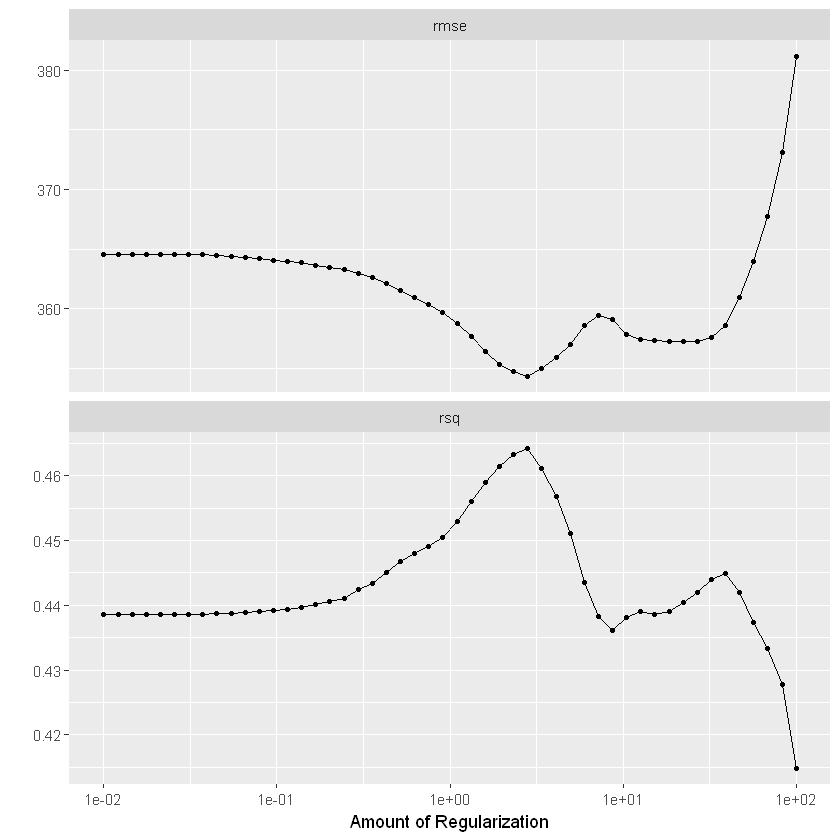
</div>

In [6]:
tune_res <- tune_grid(
  lasso_workflow,
  resamples = Hitters_fold, 
  grid = penalty_grid
)

Next, you should select the best value of `penalty` using `select_best()`. Your output variable here is `best_penalty`. Use "rsq" as the metric.

In [7]:
# *your code here* 

best_penalty <- select_best(tune_res ,metric = 'rsq')

# your code here


You should now refit using the whole training data set. Your output variable should be `lasso_final` with the function `finalize_workflow` and your second output variable should be `lasso_final_fit` with the `fit` function. 

In [8]:
lasso_final <- finalize_workflow(lasso_workflow, parameters = best_penalty)
lasso_final_fit <- fit(lasso_final, data = Hitters_train)

Finalize this by calculating the `rsq` value for the lasso model. You will see tha seee that for this data ridge regression does better than lasso regession. Verify this using the `augment` then the `rsq` function. Store the output to the variable `rsq_val`

In [9]:
# *your code here*

rsq_val <- augment(lasso_final_fit, new_data = Hitters_test) %>%
  rsq(truth = Salary, estimate = .pred)

